In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import nibabel as nib
import random
from scipy import stats
from scipy import fft
import random
import pywt.data
from PIL import Image
import pandas as pd
import seaborn as sns
import os
import pickle

In [2]:
np. __version__

'1.26.3'

In [2]:
# assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'

ROOT_DIR = BRANDON
data_dir = ROOT_DIR + 'raw-data/first_21_mri_3d'
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)
n = len(file_list)

In [3]:
image = nib.load(file_list[0]).get_fdata()

In [4]:
def getIndexDF_3d(image, no_zero =False):
    x_freqs = fft.fftfreq(image.shape[0])
    y_freqs = fft.fftfreq(image.shape[1])
    z_freqs = fft.fftfreq(image.shape[2])
    coord_df = pd.DataFrame()
    coord_df["index_coords"] = [(x,y,z) for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["x_index"] = [x for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["y_index"] = [y for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["z_index"] = [z for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["x_freq"] = [x_freqs[x] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["y_freq"] = [y_freqs[y] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["z_freq"] = [z_freqs[z] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[1]) for z in np.arange(image.shape[2])]
    coord_df["magnitude"] = np.sqrt(coord_df["x_freq"] ** 2 + coord_df["y_freq"] **2 + coord_df["z_freq"] ** 2)
    coord_df = coord_df.set_index(["index_coords"])
    coord_df = coord_df[(coord_df["x_freq"] >= 0 )& (coord_df["y_freq"] >= 0) & (coord_df["z_freq"] >= 0)]
    if no_zero:
        coord_df = coord_df[(coord_df["x_freq"] != 0 )| (coord_df["y_freq"] != 0)|(coord_df["z_freq"] != 0)]
    return coord_df

In [5]:
getIndexDF_3d(image)

,x_index,y_index,z_index,x_freq,y_freq,z_freq,magnitude
index_coords,,,,,,,
"(0, 0, 0)",0,0,0,0.00000,0.000000,0.00000,0.000000
"(0, 0, 1)",0,0,1,0.00000,0.000000,0.00625,0.006250
"(0, 0, 2)",0,0,2,0.00000,0.000000,0.01250,0.012500
"(0, 0, 3)",0,0,3,0.00000,0.000000,0.01875,0.018750
"(0, 0, 4)",0,0,4,0.00000,0.000000,0.02500,0.025000
...,...,...,...,...,...,...,...
"(79, 111, 75)",79,111,75,0.49375,0.495536,0.46875,0.842064
"(79, 111, 76)",79,111,76,0.49375,0.495536,0.47500,0.845559
"(79, 111, 77)",79,111,77,0.49375,0.495536,0.48125,0.849086


In [6]:
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
image = nib.load(file_list[0]).get_fdata()
coord_df = getIndexDF_3d(image, no_zero =False).sort_values(["magnitude"])
x = coord_df["x_index"].to_numpy()
y = coord_df["y_index"].to_numpy()
z = coord_df["z_index"].to_numpy()
magnitudes = coord_df["magnitude"]
freq_arr = [0]*len(file_list)
mag_arr = [0]*len(file_list)
for k in range(len(file_list)):
        image = nib.load(file_list[0]).get_fdata()
        transformed = np.array(fft.fftn(image))
        freq_arr[k] = transformed[tuple(x), tuple(y), tuple(z)]
        mag_arr[k] = magnitudes
sample = np.concatenate(np.array(freq_arr).T)
mag_flat = np.concatenate(np.array(mag_arr).T)
sample, mag_flat

(array([4.77799335e+10    -0.j        , 4.77799335e+10    -0.j        ,
        4.77799335e+10    -0.j        , ...,
        1.80688674e+05-93447.97935265j, 1.80688674e+05-93447.97935265j,
        1.80688674e+05-93447.97935265j]),
 array([0.        , 0.        , 0.        , ..., 0.85623231, 0.85623231,
        0.85623231]))

In [7]:
def convert_fourier_list_3d(folder_dir, ):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    image = nib.load(file_list[0]).get_fdata()
    coord_df = getIndexDF_3d(image, no_zero =False).sort_values(["magnitude"])
    x = coord_df["x_index"].to_numpy()
    y = coord_df["y_index"].to_numpy()
    z = coord_df["z_index"].to_numpy()
    magnitudes = coord_df["magnitude"]
    freq_arr = [0]*len(file_list)
    mag_arr = [0]*len(file_list)
    for k in range(len(file_list)):
        image = nib.load(file_list[0]).get_fdata()
        transformed = np.array(fft.fftn(image))
        freq_arr[k] = transformed[tuple(x), tuple(y), tuple(z)]
        mag_arr[k] = magnitudes
    sample = np.concatenate(np.array(freq_arr).T)
    mag_flat = np.concatenate(np.array(mag_arr).T)
    return sample, mag_flat

In [10]:
def recursive_split(freqs, mags, threshold =0.05, max_depth = 5, presplit = 0):
    magnitude_splits = []
    def recursive_helper(freqs, mags, magnitude_splits, depth, presplit):
        if depth > 0 and mags[0] != mags[-1]:
            n = (mags[-1] + mags[0])/2
            idx = np.argmax(mags>n)
            if presplit > 0:
                stat = threshold + 1
            else:
                first_sample = np.concatenate([np.real(freqs[:idx]),np.imag(freqs[:idx])])
                second_sample = np.concatenate([np.real(freqs[idx:]),np.imag(freqs[idx:])])
                stat = stats.ks_2samp(first_sample, second_sample).statistic
            if stat > threshold:
                magnitude_splits.append(n)
                recursive_helper(freqs[:idx], mags[:idx], magnitude_splits, depth-1, max(presplit-1, 0))
                recursive_helper(freqs[idx:], mags[idx:], magnitude_splits, depth-1, max(presplit-1, 0))
        elif mags[0] == mags[-1]:
            print(f"Both Endpoints Are The Same {mags[0]} and {mags[-1]} Recursion Depth of {max_depth - depth}")
        elif depth == 0:
            print(f"Recursion Depth Exceeded Endpoints are {mags[0]} and {mags[-1]}")
    recursive_helper(freqs, mags, magnitude_splits, max_depth, presplit)
    return magnitude_splits





In [11]:
def convert_to_fourier_basis_3d(folder_dir, threshold =0.05, max_depth = 5, presplit = 0, split_list = None):
    freqs, mags = convert_fourier_list_3d(folder_dir)
    df = pd.DataFrame(columns=["band", "magnitude_endpoints","unique_magnitudes", "data"])

    if split_list == None:
        mag_splits = recursive_split(freqs, mags, threshold, max_depth, presplit)
    else:
        mag_splits = split_list
    
    sorted_mag_split = np.sort(mag_splits)
    print(sorted_mag_split)
    prev = 0
    for i in range(len(mag_splits)):
        next_idx = np.argmax(mags>=sorted_mag_split[i])
        next_freqs = np.concatenate([np.real(freqs[prev:next_idx]),np.imag(freqs[prev:next_idx])])
        num_mags = len(np.unique(mags[prev:next_idx]))
        mag_endpoints = (min(mags[prev:next_idx]), max(mags[prev:next_idx]))

        df.loc[len(df.index)] = [i+1, mag_endpoints, num_mags, next_freqs]
        prev = next_idx

    return df

In [22]:
converted = convert_to_fourier_basis_3d(data_dir, threshold =0.02, max_depth = 9, presplit= 2)
converted["number_of_coefficents"] = converted["data"].apply(lambda x:len(x))/(2 *n)
converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 8
Both Endpoints Are The Same 0.004464285714285714 and 0.004464285714285714 Recursion Depth of 9
Both Endpoints Are The Same 0.00625 and 0.00625 Recursion Depth of 9
Both Endpoints Are The Same 0.007680647559859488 and 0.007680647559859488 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.008838834764831846 and 0.00990226473786555
Both Endpoints Are The Same 0.010898710371190806 and 0.010898710371190806 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.0125 and 0.013273275667248667
Recursion Depth Exceeded Endpoints are 0.013392857142857142 and 0.01477941549754183
Recursion Depth Exceeded Endpoints are 0.015361295119718977 and 0.01658408537589885
Recursion Depth Exceeded Endpoints are 0.01767766952966369 and 0.018750000000000003
Recursion Depth Exceeded Endpoints are 0.018919303661086687 and 0.019924922861090533
Recursion Depth Exceeded Endpoints are 0.02026215306769682 and 0.021687424645519857
Recursion

,band,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,"(0.0, 0.0)",1,"[47779933484.0, 47779933484.0, 47779933484.0, ...",1.0
1,2,"(0.004464285714285714, 0.004464285714285714)",1,"[-16214758521.574413, -16214758521.574413, -16...",1.0
2,3,"(0.00625, 0.00625)",1,"[-9879205199.709785, -9879205199.709785, -9879...",2.0
3,4,"(0.007680647559859488, 0.007680647559859488)",1,"[2829991022.1984396, 2829991022.1984396, 28299...",2.0
4,5,"(0.008838834764831846, 0.00990226473786555)",3,"[3513628056.67588, 3513628056.67588, 351362805...",3.0
...,...,...,...,...,...
176,177,"(0.588660382494327, 0.6020360331442642)",6237,"[925462.3097729231, 925462.3097729231, 925462....",21719.0
177,178,"(0.6020386814645649, 0.6154143752922308)",6060,"[1010516.5748960951, 1010516.5748960951, 10105...",20236.0
178,179,"(0.6154182614121813, 0.6421728749141544)",11160,"[-492288.67960672657, -492288.67960672657, -49...",35646.0
179,180,"(0.6421753577108206, 0.695682980008473)",17806,"[-584576.5780511233, -584576.5780511233, -5845...",49514.0


In [23]:
converted = convert_to_fourier_basis_3d(data_dir, threshold =0.02, max_depth = 9, presplit= 0)
converted["number_of_coefficents"] = converted["data"].apply(lambda x:len(x))/(2 *n)
converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 8
Both Endpoints Are The Same 0.004464285714285714 and 0.004464285714285714 Recursion Depth of 9
Both Endpoints Are The Same 0.00625 and 0.00625 Recursion Depth of 9
Both Endpoints Are The Same 0.007680647559859488 and 0.007680647559859488 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.008838834764831846 and 0.00990226473786555
Both Endpoints Are The Same 0.010898710371190806 and 0.010898710371190806 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.0125 and 0.013273275667248667
Recursion Depth Exceeded Endpoints are 0.013392857142857142 and 0.01477941549754183
Recursion Depth Exceeded Endpoints are 0.015361295119718977 and 0.01658408537589885
Recursion Depth Exceeded Endpoints are 0.01767766952966369 and 0.018750000000000003
Recursion Depth Exceeded Endpoints are 0.018919303661086687 and 0.019924922861090533
Recursion Depth Exceeded Endpoints are 0.02026215306769682 and 0.021687424645519857
Recursion

,band,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,"(0.0, 0.0)",1,"[47779933484.0, 47779933484.0, 47779933484.0, ...",1.0
1,2,"(0.004464285714285714, 0.004464285714285714)",1,"[-16214758521.574413, -16214758521.574413, -16...",1.0
2,3,"(0.00625, 0.00625)",1,"[-9879205199.709785, -9879205199.709785, -9879...",2.0
3,4,"(0.007680647559859488, 0.007680647559859488)",1,"[2829991022.1984396, 2829991022.1984396, 28299...",2.0
4,5,"(0.008838834764831846, 0.00990226473786555)",3,"[3513628056.67588, 3513628056.67588, 351362805...",3.0
...,...,...,...,...,...
176,177,"(0.588660382494327, 0.6020360331442642)",6237,"[925462.3097729231, 925462.3097729231, 925462....",21719.0
177,178,"(0.6020386814645649, 0.6154143752922308)",6060,"[1010516.5748960951, 1010516.5748960951, 10105...",20236.0
178,179,"(0.6154182614121813, 0.6421728749141544)",11160,"[-492288.67960672657, -492288.67960672657, -49...",35646.0
179,180,"(0.6421753577108206, 0.695682980008473)",17806,"[-584576.5780511233, -584576.5780511233, -5845...",49514.0


In [24]:
converted = convert_to_fourier_basis_3d(data_dir, threshold =0.03, max_depth = 9)
converted["number_of_coefficents"] = converted["data"].apply(lambda x:len(x))/(2 *n)
converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 8
Both Endpoints Are The Same 0.004464285714285714 and 0.004464285714285714 Recursion Depth of 9
Both Endpoints Are The Same 0.00625 and 0.00625 Recursion Depth of 9
Both Endpoints Are The Same 0.007680647559859488 and 0.007680647559859488 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.008838834764831846 and 0.00990226473786555
Both Endpoints Are The Same 0.010898710371190806 and 0.010898710371190806 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.0125 and 0.013273275667248667
Recursion Depth Exceeded Endpoints are 0.013392857142857142 and 0.01477941549754183
Recursion Depth Exceeded Endpoints are 0.015361295119718977 and 0.01658408537589885
Recursion Depth Exceeded Endpoints are 0.01767766952966369 and 0.018750000000000003
Recursion Depth Exceeded Endpoints are 0.018919303661086687 and 0.019924922861090533
Recursion Depth Exceeded Endpoints are 0.02026215306769682 and 0.021687424645519857
Recursion

,band,magnitude_endpoints,unique_magnitudes,data,number_of_coefficents
0,1,"(0.0, 0.0)",1,"[47779933484.0, 47779933484.0, 47779933484.0, ...",1.0
1,2,"(0.004464285714285714, 0.004464285714285714)",1,"[-16214758521.574413, -16214758521.574413, -16...",1.0
2,3,"(0.00625, 0.00625)",1,"[-9879205199.709785, -9879205199.709785, -9879...",2.0
3,4,"(0.007680647559859488, 0.007680647559859488)",1,"[2829991022.1984396, 2829991022.1984396, 28299...",2.0
4,5,"(0.008838834764831846, 0.00990226473786555)",3,"[3513628056.67588, 3513628056.67588, 351362805...",3.0
...,...,...,...,...,...
112,113,"(0.5083902227840824, 0.5351447865783996)",13779,"[538567.8376235683, 538567.8376235683, 538567....",56962.0
113,114,"(0.5351462762551897, 0.5619023185227344)",13520,"[-792366.9147590024, -792366.9147590024, -7923...",52586.0
114,115,"(0.5619051559976422, 0.5886590282418271)",12962,"[1463718.9726669993, 1463718.9726669993, 14637...",47640.0
115,116,"(0.588660382494327, 0.6154143752922308)",12297,"[925462.3097729231, 925462.3097729231, 925462....",41955.0


 
0.02726 x - 3.988


1.0276344954831453

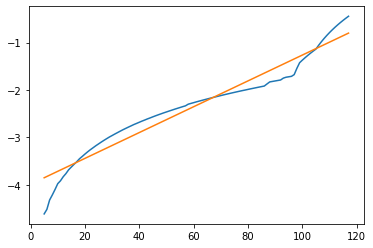

In [25]:
converted["magnitude_length"] = converted["magnitude_endpoints"].apply(lambda x: x[1] - x[0])
x = np.asfarray(converted["band"][4:].to_numpy())
y = np.asfarray(converted["magnitude_endpoints"].apply(lambda x: x[1])[4:].to_numpy())
logy = np.log(y)
plt.plot(x, logy)
print(np.poly1d(np.polyfit(x, logy, 1)))
plt.plot(x, np.poly1d(np.polyfit(x, logy, 1))(x))
np.exp(np.polyfit(x, logy, 1)[0])

# Unique Magnitude

In [20]:
def uniqueMags(folder_dir, start = None, end = None, dim="2d"):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    image = np.array(Image.open(file_list[0]).convert('L'))
    if dim == "2d":
        coord_df = getIndexDF(image, no_zero =False).sort_values(["magnitude"])
    if dim == "3d":
        coord_df = getIndexDF_3d(image, no_zero =False).sort_values(["magnitude"])
    magnitudes = np.unique(coord_df["magnitude"])
    if start != None:
        start_idx = np.argmax(magnitudes >= start)
        magnitudes = magnitudes[start_idx:]
    if end != None:
        end_idx = np.argmax(magnitudes > end)
        magnitudes = magnitudes[:end_idx]
    return magnitudes.tolist()


In [21]:
unique_splits = uniqueMags(data_dir,0, 0.008052940675034493 )[1:]
unique_splits

[0.001953125,
 0.0027621358640099515,
 0.00390625,
 0.004367320268554277,
 0.005524271728019903,
 0.005859375,
 0.006176323555016366,
 0.007042092334890604,
 0.0078125,
 0.008052940675034493]

# New Dataset Stuff

In [22]:
def getSplits(minfreq, maxfreq, mult):
    arr = []
    next_freq = minfreq
    while next_freq < maxfreq:
        arr.append(next_freq)
        next_freq *= mult
    return arr
splits = getSplits(0.008052940675034493,0.5282291467669505, 1.35)
splits
    


[0.008052940675034493,
 0.010871469911296566,
 0.014676484380250364,
 0.01981325391333799,
 0.02674789278300629,
 0.0361096552570585,
 0.04874803459702898,
 0.06580984670598912,
 0.08884329305308532,
 0.11993844562166518,
 0.161916901589248,
 0.21858781714548484,
 0.29509355314640456,
 0.3983762967476462]